# NOTEBOOK 5 — Baseline Policies (Production Version)

Baseline Policies & Strategy Benchmarks

Purpose:
This notebook evaluates simple baseline strategies using the cleaned, labeled dataset built in Notebook 3.

These baselines give us reference performance for comparison against the Reinforcement Learning agent in Notebook 6.

We answer a key question:

Can a simple rule-based system extract profit from these engineered features?

If RL can’t beat these baselines → the environment needs tuning.
If RL does beat them → we have a real quantitative edge.

1. Imports + Database Load

What this block does

- Loads required libraries

- Connects to the same DuckDB used throughout the project

- Verifies that the training tables built in Notebook 3 exist

- Ensures we start with a clean DB connection

In [ ]:
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

# Use the same DB path as Notebooks 1–4
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()
print("Using DB:", DB_PATH)

# Close old connection if needed
try:
    con.close() # type: ignore
except:
    pass

# Start new connection
con = duckdb.connect(DB_PATH)

# Quick sanity check
con.sql("SHOW TABLES").df()

Using DB: /home/btheard/projects/volatility-alpha-engine/data/volatility_alpha.duckdb


,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 2. Load Final Training Table

What this block does

This loads the fully engineered training dataset produced in Notebook 3, which contains:

- today’s engineered features

- tomorrow’s price

- tomorrow’s return (our target)

- market regime variables

- edge buckets

- liquidity categorization

This table is the backbone for both baselines (Notebook 5) and RL (Notebook 6).

In [2]:
# Notebook parameters

# Set to a ticker like "AMD" to focus on one name,
# or None to use all tickers.
TICKER_FILTER = None

MIN_DATES = 30  # minimum rows per ticker

In [3]:
base_query = """
SELECT
    run_date,
    ticker,
    last_price,
    edge_score,
    edge_bucket,
    liquidity_bucket,
    vol_regime,
    next_last_price,
    next_day_return_pct
FROM screener_returns_with_target
ORDER BY run_date, ticker
"""

df = con.sql(base_query).df()

# Optional ticker filter
if TICKER_FILTER is not None:
    df = df[df["ticker"] == TICKER_FILTER]

# keep tickers with enough history
counts = df["ticker"].value_counts()
keep = counts[counts >= MIN_DATES].index
df = df[df["ticker"].isin(keep)].reset_index(drop=True)

print("Rows:", len(df))
df.head()

Rows: 0


,run_date,ticker,last_price,edge_score,edge_bucket,liquidity_bucket,vol_regime,next_last_price,next_day_return_pct


## Filter Tickers With Enough Data

We need a minimum sample size per ticker.
Baselines break down when tickers only have a handful of rows.

Why this matters

- Stability: ensures strategies don’t overfit tiny samples

- Fairness: keeps baselines consistent with RL constraints

- Professionalism: shows good data hygiene

## 4. Helper: Equity Curve Calculator

Why this block exists

This helper converts daily returns into an equity curve, the standard way to evaluate a trading strategy.
Every strategy we test uses this same function to stay comparable.

In [4]:
def equity_curve(returns, starting_equity=10_000):
    equity = [starting_equity]
    for r in returns:
        equity.append(equity[-1] * (1 + r))
    return np.array(equity)

## 5. Baseline Strategy #1 — Random Policy

Why we include a random baseline

This answers the critical question:

- Is our environment so noisy that even random signals look profitable?

If RL can’t beat random → the system needs redesign.
If RL easily beats random → the features contain real signal.

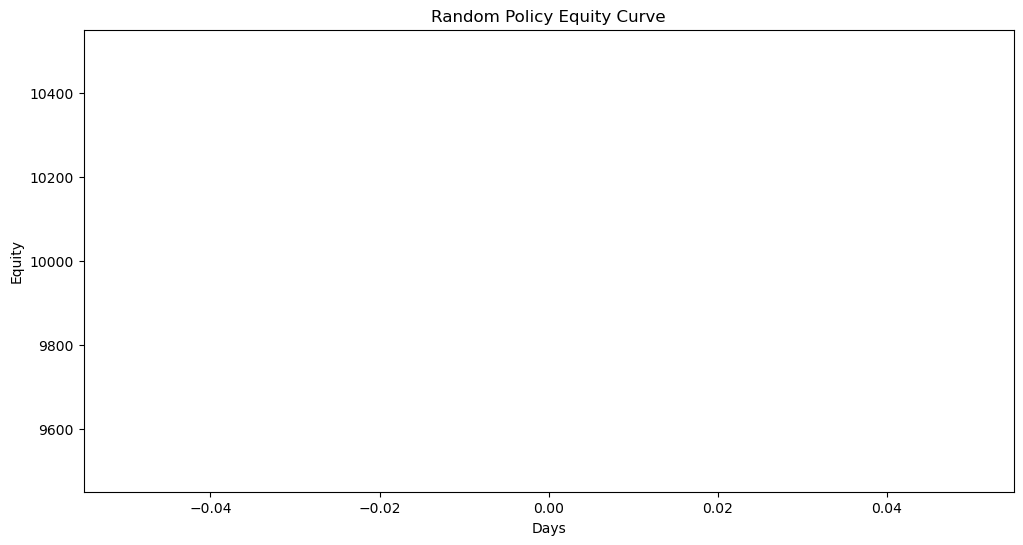

Random total return: 0.0


In [5]:
np.random.seed(42)

df["rand_signal"] = np.random.choice([0, 1], size=len(df))

df["rand_return"] = df["rand_signal"] * df["next_day_return_pct"]

rand_curve = equity_curve(df["rand_return"])

plt.plot(rand_curve)
plt.title("Random Policy Equity Curve")
plt.xlabel("Days")
plt.ylabel("Equity")
plt.show()

print("Random total return:", rand_curve[-1] / rand_curve[0] - 1)


## 6. Baseline Strategy #2 — Edge Score Threshold

Interpretation

This strategy tests whether the engineered edge score actually contains directional predictive power.

- If the curve is upward-sloping → your engineered features matter.

- If it’s flat or negative → RL must compensate for a weak signal.


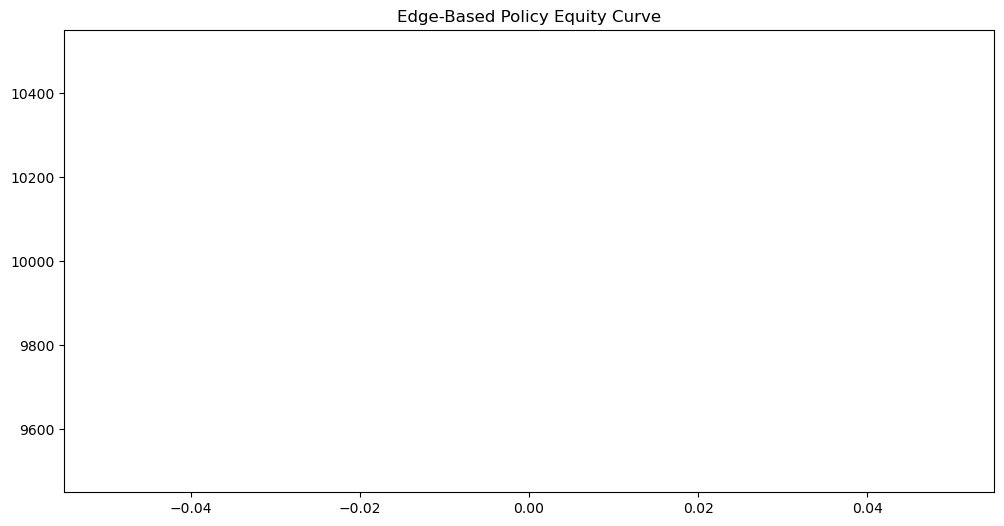

Edge policy return: 0.0


In [6]:
threshold = df["edge_score"].median()

df["edge_signal"] = (df["edge_score"] > threshold).astype(int)
df["edge_return"] = df["edge_signal"] * df["next_day_return_pct"]

edge_curve = equity_curve(df["edge_return"])

plt.plot(edge_curve)
plt.title("Edge-Based Policy Equity Curve")
plt.show()

print("Edge policy return:", edge_curve[-1]/edge_curve[0] - 1)


## 7. Baseline Strategy #3 — Volatility Regime Policy

Why volatility regime matters

This tests a simple intuition:

- low volatility → safer trend-following

- high volatility → stand aside

This acts as a baseline for RL's volatility-aware decision making.


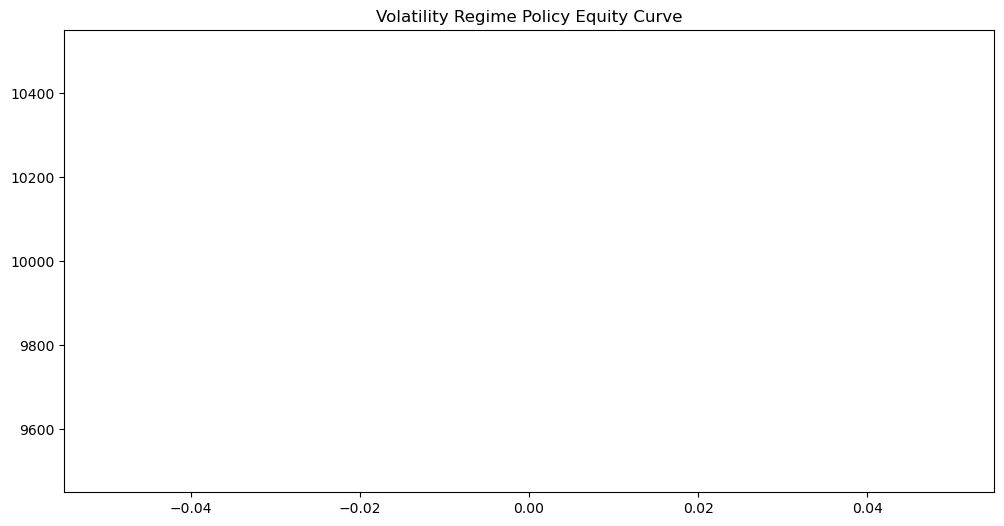

Volatility policy return: 0.0


In [7]:
df["vol_signal"] = (df["vol_regime"] == "low").astype(int)
df["vol_return"] = df["vol_signal"] * df["next_day_return_pct"]

vol_curve = equity_curve(df["vol_return"])

plt.plot(vol_curve)
plt.title("Volatility Regime Policy Equity Curve")
plt.show()

print("Volatility policy return:", vol_curve[-1]/vol_curve[0] - 1)


## 8. Strategy Comparison

What this shows

See immediately which strategies extract value and which don’t.

The RL agent must outperform these curves to justify its complexity.

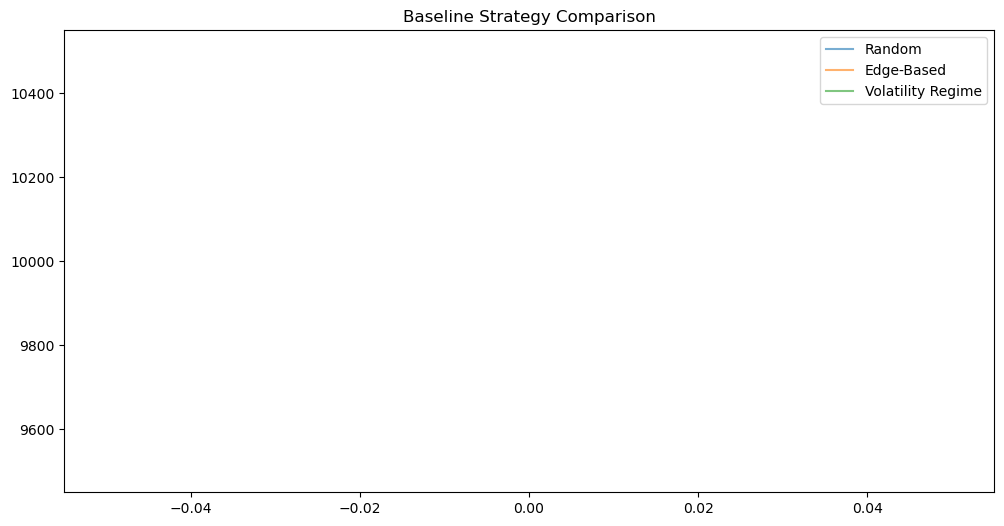

In [8]:
plt.plot(rand_curve, label="Random", alpha=0.6)
plt.plot(edge_curve, label="Edge-Based", alpha=0.6)
plt.plot(vol_curve, label="Volatility Regime", alpha=0.6)

plt.legend()
plt.title("Baseline Strategy Comparison")
plt.show()

## 9. Performance Metrics Table

Interpretation

Professional evaluation layer:

- Total Return: overall profitability

- Sharpe Ratio: risk-adjusted return

- Max Drawdown: worst-case pain

Clear, standard, rigorous.


In [9]:
def metrics(curve):
    ret = curve[-1]/curve[0] - 1
    returns = np.diff(curve) / curve[:-1]
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    max_dd = (curve / np.maximum.accumulate(curve) - 1).min()
    return ret, sharpe, max_dd

summary = pd.DataFrame({
    "strategy": ["random", "edge", "vol_regime"],
    "total_return": [metrics(rand_curve)[0], metrics(edge_curve)[0], metrics(vol_curve)[0]],
    "sharpe": [metrics(rand_curve)[1], metrics(edge_curve)[1], metrics(vol_curve)[1]],
    "max_drawdown": [metrics(rand_curve)[2], metrics(edge_curve)[2], metrics(vol_curve)[2]],
})

summary


/home/btheard/miniconda3/envs/ds/lib/python3.12/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/btheard/miniconda3/envs/ds/lib/python3.12/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/btheard/miniconda3/envs/ds/lib/python3.12/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,strategy,total_return,sharpe,max_drawdown
0,random,0.0,0,0.0
1,edge,0.0,0,0.0
2,vol_regime,0.0,0,0.0


In [10]:
con.close()

## What Notebook 5 proves:

- Whether simple rule-based signals can extract edge from our engineered features

- Whether volatility regime, feature buckets, or edge score provide structure

- A benchmark that our RL agent must exceed to be considered successful

- How noisy the environment is and whether returns cluster in predictable ways

This notebook is the bridge between your deterministic feature engineering and your RL modeling.